```
This software is part of GPU Ocean. 

Copyright (C) 2023 SINTEF Digital

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# My own steady state

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from scipy import integrate

#For plotting
from matplotlib import pyplot as plt
import matplotlib as mpl
plt.rcParams["animation.html"] = "jshtml"
mpl.rcParams['figure.facecolor'] = 'white'
plt.rcParams["image.origin"] = "lower"


from gpuocean.SWEsimulators import CDKLM16, KP07
from gpuocean.utils import Common, IPythonMagic


In [2]:
%cuda_context_handler gpu_ctx


### Initial conditions

\begin{equation}
    \eta(x,y) = e^{-b(x^2 + y^2)}
\end{equation}

This gives steady state currents
\begin{equation}
    \begin{split}
    hv(x,y) &= -\frac{g(\eta(x,y) + H)}{f}2xb e^{-b(x^2 + y^2)} \\
    hu(x,y) &= \; \frac{g(\eta(x,y) + H)}{f}2yb e^{-b(x^2 + y^2)}
    \end{split}
\end{equation}


In [3]:
nx = 401
ny = 401
domain_size = 50*1000
x_start = -domain_size
x_end = domain_size
y_start = -domain_size
y_end = domain_size

b = 10e-9
a = 0.1

sim_args = {
    "gpu_ctx" : gpu_ctx,
    "nx" : nx, "ny" : ny,
    "dx" : (x_end - x_start)/nx, 
    "dy" : (y_end - y_start)/ny,
    "f" : 0.0012,
    "g" : 9.81,
    "r" : 0,
    #"rk_order": 3
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
}

cdklm_args = {
    "courant_number" : 0.5,
    "dt" : 0
}

x = np.arange(x_start+0.5*sim_args["dx"], x_end, sim_args["dx"])
y = np.arange(y_start+0.5*sim_args["dx"], y_end, sim_args["dy"])

sim_args["f"], sim_args["g"], x[200], y[200]

(0.0012, 9.81, 4.0745362639427185e-10, 4.0745362639427185e-10)

In [4]:
def init_eta(x, y, a, b):
    #     \eta(x,y) = e^{-b(x^2 + y^2)}
    return a*np.exp(-b*(x*x + y*y))

def deta_dx(x, y, a, b):
    return -a*2*b*x*np.exp(-b*(x*x + y*y))
def deta_dy(x, y, a, b):
    return -a*2*b*y*np.exp(-b*(x*x + y*y))

def init_hv(x, y, a, b, H, g, f):
    #     hv(x,y) &= -\frac{g(\eta(x,y) + H)}{f}2xb e^{-b(x^2 + y^2)} \\
    return  (g*(init_eta(x,y,a,b) + H)/f)*deta_dx(x, y, a, b)

def init_hu(x, y, a, b, H, g, f):
    #     hu(x,y) &= \; \frac{g(\eta(x,y) + H)}{f}2yb e^{-b(x^2 + y^2)}
    return  -(g*(init_eta(x,y,a,b) + H)/f)*deta_dy(x, y, a, b)
    
def numerical_hv(eta, H, g, f, dx):
    hv = np.zeros_like(eta)
    hv[1:-1, 1:-1] = (eta[1:-1, 2:] - eta[1:-1, :-2])/(2*dx)
    hv = hv* g*(eta + H)/f
    return hv

def numerical_hu(eta, H, g, f, dy, theta):
    hu = np.zeros_like(eta)
    central_diff  =       (eta[2:,   1:-1] - eta[ :-2, 1:-1])/(2*dy)
    backward_diff = theta*(eta[1:-1, 1:-1] - eta[ :-2, 1:-1])/dy
    forward_diff  = theta*(eta[2:,   1:-1] - eta[1:-1, 1:-1])/dy
    (nx, ny) = central_diff.shape
    for j in range(ny):
        for i in range(nx):
            central =   central_diff[j,i]
            backward = backward_diff[j,i]
            forward  =  forward_diff[j,i]
            if   central > 0 and backward > 0 and forward > 0:
                hu[j+1, i+1] = min(central, backward, forward)
            elif central < 0 and backward < 0 and forward < 0:
                hu[j+1, i+1] = max(central, backward, forward)
    hu = -hu* g*(eta + H)/f
    return hu

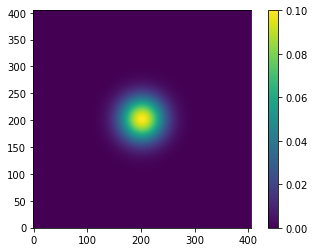

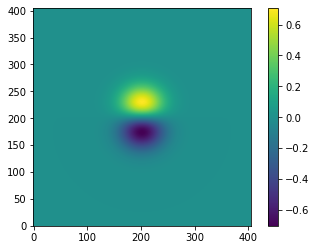

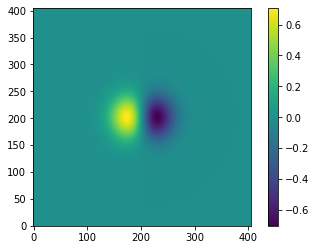

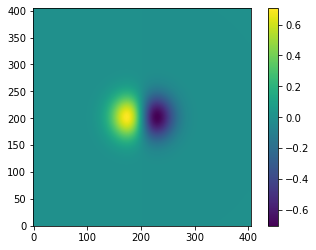

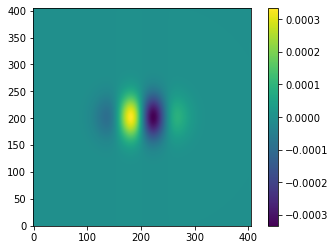

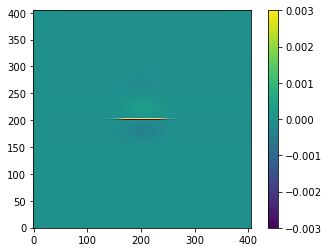

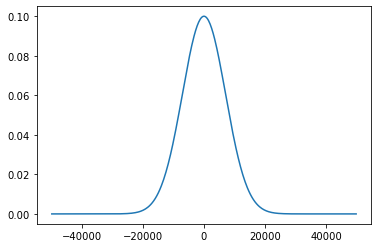

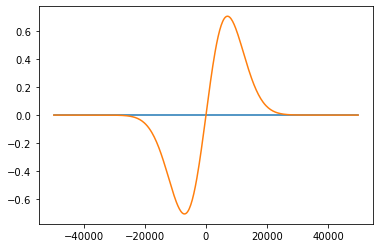

In [5]:
dataShape = (sim_args["ny"] + 4, 
             sim_args["nx"] + 4)

H_const = 10.0
H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * H_const
eta0 = np.zeros(dataShape, dtype=np.float64)
hu0 = np.zeros(dataShape, dtype=np.float64)
hv0 = np.zeros(dataShape, dtype=np.float64)

for j in range(ny):
    for i in range(nx):
        eta0[2+j, 2+i] = init_eta(x[i], y[j], a, b) 
        hu0[2+j, 2+i] =  init_hu( x[i], y[j], a, b, H_const, sim_args["g"], sim_args["f"])
        hv0[2+j, 2+i] =  init_hv( x[i], y[j], a, b, H_const, sim_args["g"], sim_args["f"])

num_hv0 = numerical_hv(eta0, H_const, sim_args["g"], sim_args["f"], sim_args["dx"])
num_hu0 = numerical_hu(eta0, H_const, sim_args["g"], sim_args["f"], sim_args["dy"], 1.5)

data_args = {
    "H" : H, 
    "eta0" : eta0.astype(np.float32), 
    "hu0": hu0.astype(np.float32), 
    "hv0": hv0.astype(np.float32)
}


plt.figure()
plt.imshow(data_args["eta0"], origin="lower")
plt.colorbar()

plt.figure()
plt.imshow(data_args["hu0"], origin="lower")
plt.colorbar()

plt.figure()
plt.imshow(data_args["hv0"], origin="lower")
plt.colorbar()


plt.figure()
plt.imshow(num_hv0, origin="lower")
plt.colorbar()

plt.figure()
plt.imshow(hv0 - num_hv0, origin="lower")
plt.colorbar()
plt.figure()
plt.imshow(hu0 - num_hu0, origin="lower", vmin=-0.003, vmax=0.003)
plt.colorbar()


plt.figure()
plt.plot(x, eta0[2:-2, sim_args["nx"]//2 + 2])
plt.figure()
plt.plot(x, hv0[2:-2, sim_args["nx"]//2 + 2])
plt.plot(x, hu0[2:-2, sim_args["nx"]//2 + 2])

In [7]:
if "sim" in globals():
    sim.cleanUp()

sim = CDKLM16.CDKLM16(**data_args, **sim_args, **cdklm_args, theta=1.7, central_upwind=True)
error_cu = np.zeros(21)
for i in range(1, 21):
    sim.step(1000)
    eta, hu, hv = sim.download(interior_domain_only=False)
    eta_diff = eta0 - eta
    error_cu[i] = np.linalg.norm(eta_diff)




C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\SWEsimulators\CDKLM16.py:221: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  jit_compile_args={


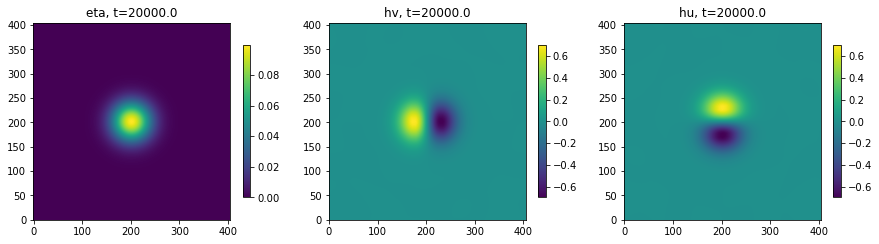

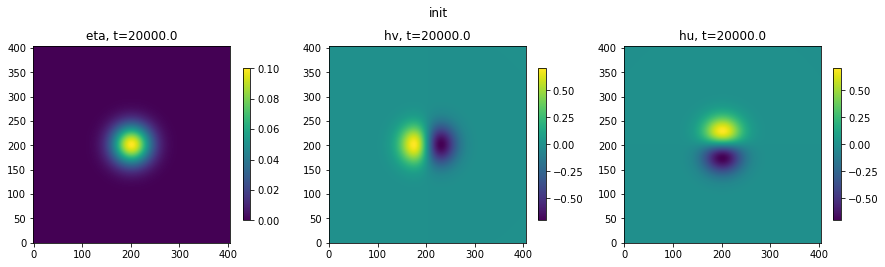

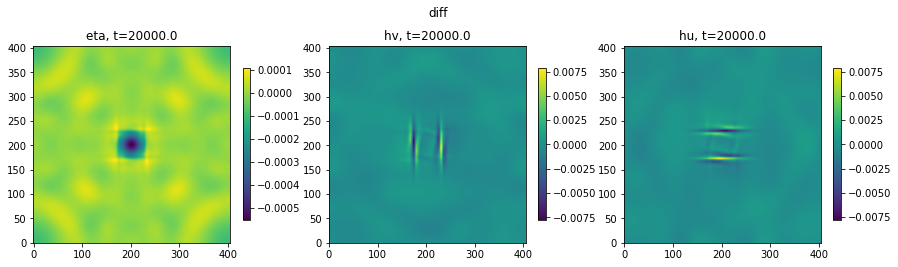

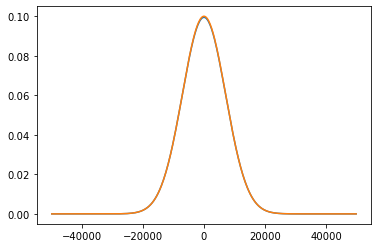

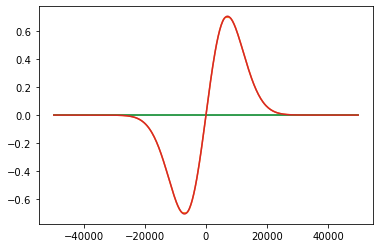

In [8]:
def plot3(eta, hu, hv, title=None):
    fig = plt.figure(figsize=(15,4))
    ax_eta = plt.subplot(1,3,1)
    im_eta = ax_eta.imshow(eta)
    ax_eta.set_title("eta, t="+str(sim.t))
    plt.colorbar(im_eta, shrink=0.7)
    
    ax_v = plt.subplot(1,3,2)
    im_v = ax_v.imshow(hv)
    ax_v.set_title("hv, t="+str(sim.t))
    plt.colorbar(im_v, shrink=0.7)


    ax_hv = plt.subplot(1,3,3)
    im_u = ax_hv.imshow(hu)
    ax_hv.set_title("hu, t="+str(sim.t))
    plt.colorbar(im_u, shrink=0.7)

    plt.suptitle(title)

plot3(eta, hu, hv)
plot3(eta0, hu0, hv0, "init")
plot3(eta-eta0, hu-hu0, hv-hv0, "diff")

plt.figure()
plt.plot(x, eta[2:-2, nx//2+2])
plt.plot(x, eta0[2:-2, nx//2+2])
plt.figure()
plt.plot(x, hv[2:-2, nx//2+2])
plt.plot(x, hu[2:-2, nx//2+2])
plt.plot(x, hv0[2:-2, nx//2+2])
plt.plot(x, hu0[2:-2, nx//2+2])



In [9]:
sim.dt

3.1148366928100586

In [13]:
if "su_sim" in globals():
    su_sim.cleanUp()
from importlib import reload

reload(CDKLM16)
reload(KP07)


su_sim = CDKLM16.CDKLM16(**data_args, **sim_args, **cdklm_args, central_upwind=False, theta=1.7, 
                         flux_delimiter=0.9)
error_su = np.zeros(21)
error_t = np.zeros(21)
for i in range(1, 21):
    su_sim.step(1000)
    su_eta, su_hu, su_hv = su_sim.download(interior_domain_only=False)
    eta_diff = eta0 - su_eta
    error_su[i] = np.linalg.norm(eta_diff)
    error_t[i] = su_sim.t




C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\SWEsimulators\CDKLM16.py:223: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  }


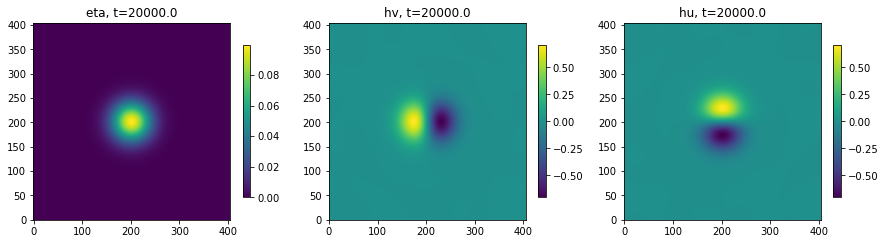

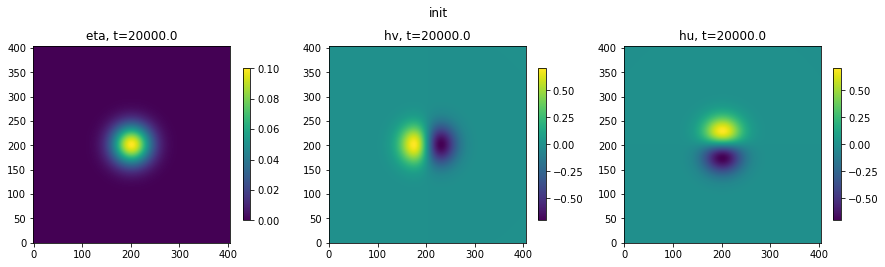

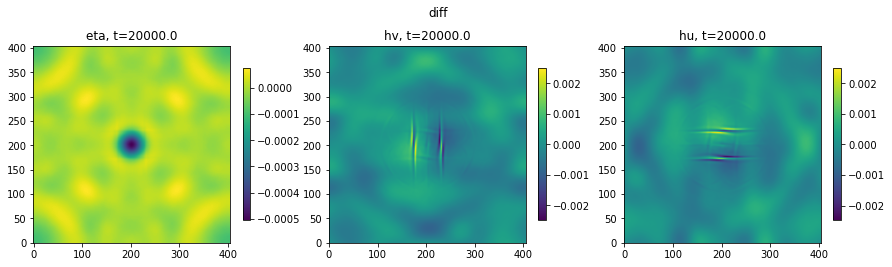

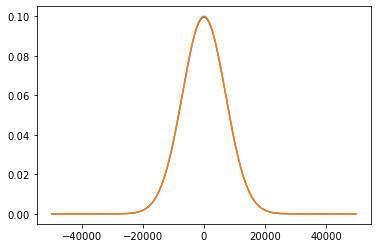

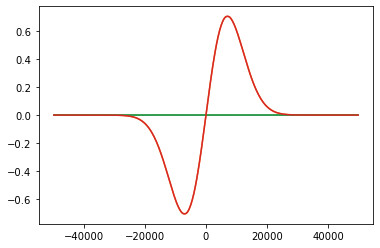

In [14]:


plot3(su_eta, su_hu, su_hv)
plot3(eta0, hu0, hv0, "init")
plot3(su_eta-eta0, su_hu-hu0, su_hv-hv0, "diff")

plt.figure()
plt.plot(x, su_eta[2:-2, nx//2+2])
plt.plot(x, eta0[2:-2, nx//2+2])
plt.figure()
plt.plot(x, su_hv[2:-2, nx//2+2])
plt.plot(x, su_hu[2:-2, nx//2+2])
plt.plot(x, hv0[2:-2, nx//2+2])
plt.plot(x, hu0[2:-2, nx//2+2])

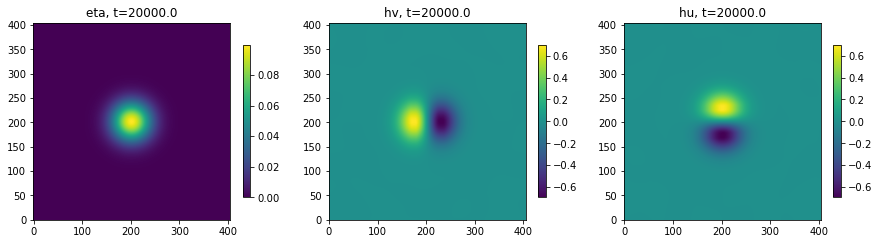

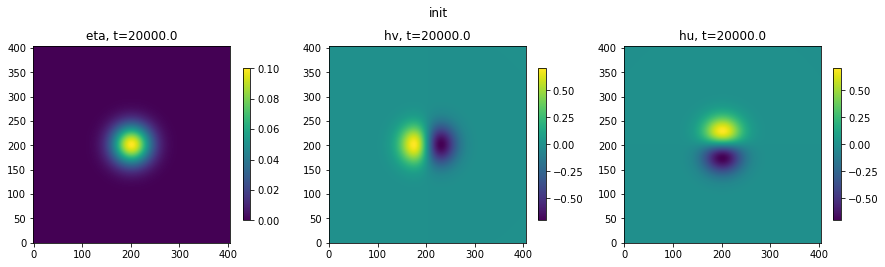

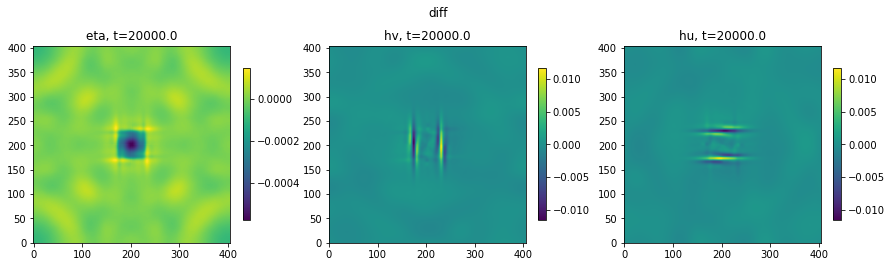

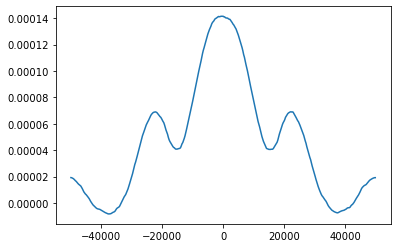

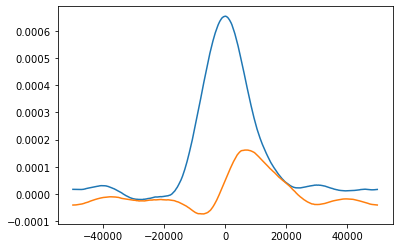

In [12]:
if "kp_sim" in globals():
    kp_sim.cleanUp()


kp_sim = KP07.KP07(**data_args, **sim_args, dt=su_sim.dt, theta=1.5)
error_kp = np.zeros(21)
error_t = np.zeros(21)
for i in range(1, 21):
    kp_sim.step(1000)
    kp_eta, kp_hu, kp_hv = kp_sim.download(interior_domain_only=False)
    eta_diff = eta0 - kp_eta
    error_kp[i] = np.linalg.norm(eta_diff)
    error_t[i] = kp_sim.t
kp_u = kp_hu/(kp_eta + H_const)
kp_v = kp_hv/(kp_eta + H_const)




plot3(kp_eta, kp_hu, kp_hv)
plot3(eta0, hu0, hv0, "init")
plot3(kp_eta-eta0, kp_hu-hu0, kp_hv-hv0, "diff")

plt.figure()
plt.plot(x, kp_eta[2:-2, 100])
plt.figure()
plt.plot(x, kp_v[2:-2, 100])
plt.plot(x, kp_u[2:-2, 100])


3.116902007604949e-05


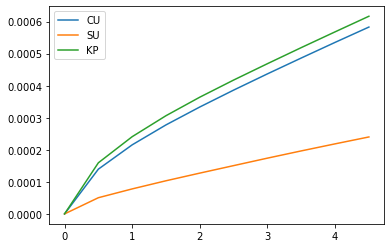

In [ ]:
print(sim.dt)
plt.figure()
plt.plot(error_t[0:10], error_cu[0:10], label='CU')
plt.plot(error_t[0:10], error_su[0:10], label='SU')
plt.plot(error_t[0:10], error_kp[0:10], label="KP")
plt.legend()

In [ ]:
1*2*2*2

8